## Training a new model

**If the pretrained models do not give satisfactory performance on your data, it is easy to train your own classifier through SpikeInterface!**

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import spikeinterface as si
import spikeinterface.extractors as se
import spikeinterface.postprocessing as spost
import spikeinterface.qualitymetrics as sqm
import os
from os import cpu_count
import json
# Set the number of CPU cores to be used globally - defaults to all cores -1
n_cores = cpu_count() -1
si.set_global_job_kwargs(n_jobs = n_cores)
print(f"Number of cores set to: {n_cores}")

# SET OUTPUT FOLDER
output_folder =  Path(r'E:\spikeinterface_repository_stuff')

Number of cores set to: 23


# Load data 

## First step: Loading the recording and sorting objects

For the tutorial, we are using simulated data to create recording and sorting objects.

In [2]:
recording = si.generate_recording(num_channels=50, sampling_frequency=30000.,
                               durations=[30], set_probe=True)
# load your recoring depeding on the acquistion software you used, for example:
# recording = se.read_spikeglx(recording_path, stream_name='imec0.ap')

labelled_sorting = si.generate_sorting(num_units=100, sampling_frequency=30000., durations=[30],
                            firing_rates=15, refractory_period_ms=1.5)
# load your sorting depeding on the which spike sorter you used, for example:
# sorting = se.read_kilosort(folder_path)

### Step 2: Create a SortingAnalyzer

Create a SpikeInterface SortingAnalyzer object. In this example, we use simulated data and generate random labels for the units, which serve as our target for training.

Important: The labels generated here are random, so the model's performance will be at chance level. 

**For real applications, replace this with your own data and curated labels to achieve meaningful results.**

To know more about sorting analyzer, please refer to : https://spikeinterface.readthedocs.io/en/latest/modules/postprocessing.html

If you have already have WaveformExtractor from previous run, you can use it to create a SortingAnalyzer. 
Please refer to: https://spikeinterface.readthedocs.io/en/latest/tutorials/waveform_extractor_to_sorting_analyzer.html

In [ ]:
analyzer = si.create_sorting_analyzer(sorting = labelled_sorting, recording = recording, sparse = True)

### Step 3: Compute quality metrics
Compute metrics from multiple SortingAnalyzer objects (each corresponding to a different recording).
Pass the metrics as a list to the model training function.

In [13]:
# Defines a function to compute all analyzer properties and quality metrics
# Note: this can be a time-consuming step, especially computing PCA-based metrics for long recordings

def compute_all_metrics(analyzer):

    # Compute required extensions for quality metrics
    analyzer.compute({
	'noise_levels': {},
	'random_spikes': {'max_spikes_per_unit': 1_000},
	'templates': {'ms_before': 1.5, 'ms_after': 3.5},
	'spike_amplitudes': {},
	'waveforms': {},
	'principal_components': {},
	'spike_locations': {},
	'unit_locations': {},
	})

    # Compute all available quality metrics
    analyzer.compute("quality_metrics", metric_names = sqm.get_quality_metric_list() + sqm.get_quality_pca_metric_list())
    analyzer.compute("template_metrics", metric_names = spost.get_template_metric_names())

	# Make metric dataframe
    quality_metrics = analyzer.extensions['quality_metrics'].data["metrics"]
    template_metrics = analyzer.extensions['template_metrics'].data["metrics"]
    calculated_metrics = pd.concat([quality_metrics, template_metrics], axis = 1)

    return calculated_metrics

In [ ]:
# Compute all metrics
metrics = compute_all_metrics(analyzer)
metrics.index.name = 'cluster_id'

# save the analyzer
analyzer.save_as(folder=output_folder / 'sorting_analyzer', format="binary_folder")

###  Add labels on which your model will be trained on

Provide a single list of labels in the same order as the metrics.

Flexible Labeling:
The set of unique labels you use is upto your requirements. 

This approach can be used for any cluster categorization task, whether you're sorting clusters into custom categories 'true' or 'false', or using standard labels like 'good', 'mua', and 'noise'.

In [ ]:
labelled_analyzer = si.load_sorting_analyzer(folder= output_folder / 'sorting_analyzer', format="binary_folder")

In [13]:
label_conversion = {'noise': 0, 'good': 1}

# These are assigned randomly here but you could load these from phy 'cluster_group.tsv', from the 'quality' property of the sorting, or similar
human_labels = np.random.choice(list(label_conversion.values()), labelled_analyzer.get_num_units())
labelled_analyzer.sorting.set_property('quality', human_labels)

labels = [human_labels.tolist(), human_labels.tolist()]

# Get labels from phy sorting (if loaded) using:
# human_labels = unlabelled_analyzer.sorting.get_property('quality')

### Step 4: Train with Your Data
Load your data and corresponding curation labels, and use them to train the classifier. Experiment to see how well the model performs on your data!

Note: For better generalizability, you’ll likely need multiple labeled recordings for training. 
The best model is saved as 'best_model.skops' file. You can use this file to predict labels on other recorindgs by auto_label_unit() 

In [6]:
# Load labelled metrics and train model
from spikeinterface.curation.train_manual_curation import train_model

# We will use a list of two (identical) analyzers here, we would advise using more than one to improve model performance
trainer = train_model(mode = "analyzers",
    labels = labels,
    analyzers = [labelled_analyzer, labelled_analyzer],
    output_folder = str(output_folder), # Optional, can be set to save the model and model_info.json file
    metric_names = None, # Can be set to specify which metrics to use for training
    imputation_strategies = None, # Default to all
    scaling_techniques = None, # Default to all
    classifiers = None, # Default to Random Forest only. Other classifiers you can try [ "AdaBoostClassifier","GradientBoostingClassifier",
                                                                # "LogisticRegression","MLPClassifier"]
    seed = None)

best_model = trainer.best_pipeline
best_model

 
# OR load model from file
# import skops.io
# pipeline_path = Path(output_folder) / Path("best_model_label.skops")
# unknown_types = skops.io.get_untrusted_types(file=pipeline_path)
# best_model = skops.io.load(pipeline_path, trusted=unknown_types)

C:\Users\jain\Documents\Github_extend\spikeinterface\src\spikeinterface\curation\train_manual_curation.py:168: UserWarning: No metric_names provided, using all metrics calculated by the analyzers
  warnings.warn("No metric_names provided, using all metrics calculated by the analyzers")


Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        min_samples_leaf=4, min_samples_split=3,
                                        random_state=1127402010))])

In [10]:
# Load and disply top 5 pipelines and accuracies
accuracies = pd.read_csv(Path(output_folder) / "model_accuracies.csv", index_col = 0)
accuracies.head()

classifier name imputation_strategy  scaling_strategy  accuracy  \
0  RandomForestClassifier              median  StandardScaler()     0.899   
1  RandomForestClassifier              median    MinMaxScaler()     0.899   
2  RandomForestClassifier              median    RobustScaler()     0.899   
3  RandomForestClassifier       most_frequent  StandardScaler()     0.899   
4  RandomForestClassifier       most_frequent    MinMaxScaler()     0.899   

   precision  recall  model_id  \
0      0.899   0.899         0   
1      0.899   0.899         1   
2      0.899   0.899         2   
3      0.899   0.899         3   
4      0.899   0.899         4   

                                         best_params  
0  OrderedDict([('class_weight', 'balanced_subsam...  
1  OrderedDict([('class_weight', 'balanced'), ('c...  
2  OrderedDict([('class_weight', 'balanced_subsam...  
3  OrderedDict([('class_weight', 'balanced_subsam...  
4  OrderedDict([('class_weight', 'balanced'), ('c...

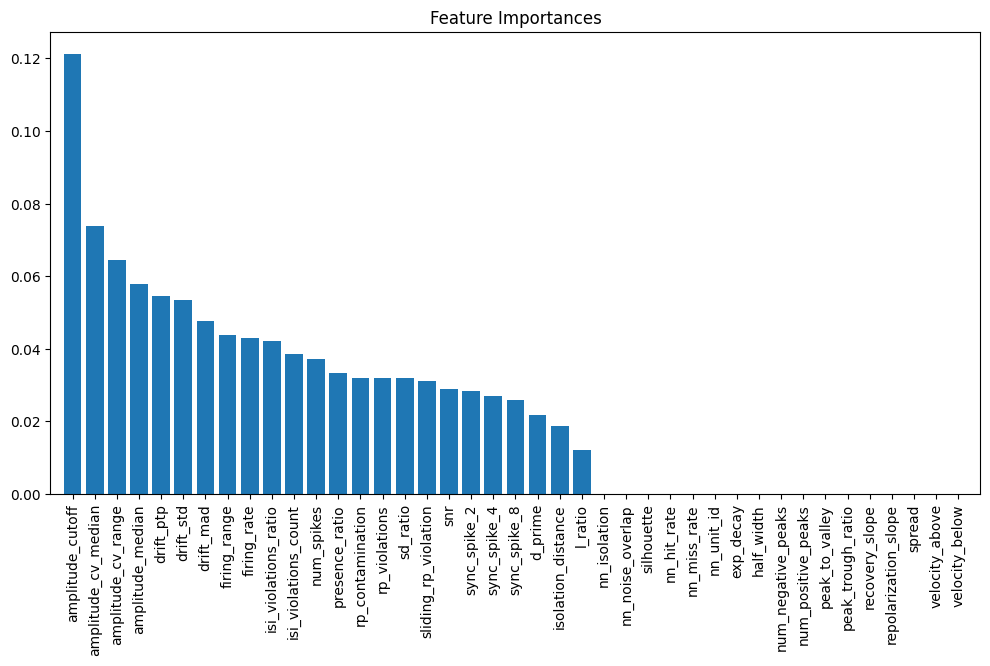

In [11]:
# Plot feature importances
importances = best_model.named_steps['classifier'].feature_importances_
indices = np.argsort(importances)[::-1]
features = best_model.feature_names_in_
n_features = best_model.n_features_in_

plt.figure(figsize=(12, 6))
plt.title("Feature Importances")
plt.bar(range(n_features), importances[indices], align="center")
plt.xticks(range(n_features), features, rotation=90)
plt.xlim([-1, n_features])
plt.show()